In [ ]:
! apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
! pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
! pip install protobuf~=3.20.3
! pip install -q tensorflow_datasets
! pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


Import the necessary modules:

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)  Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/208106 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete5FFRLE/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/4805 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete5FFRLE/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/5476 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete5FFRLE/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0. Subsequent calls will reuse this data.


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Russian:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
s
  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Russian:
к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

> Examples in English:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


### Set up the tokenizer

In [ ]:
! unzip "/content/russian_english_tokenizer.zip"
model_name = 'russian_english_tokenizer'


Archive:  /content/russian_english_tokenizer.zip
   creating: russian_english_tokenizer/
   creating: russian_english_tokenizer/assets/
  inflating: russian_english_tokenizer/assets/russian_vocab.txt  
  inflating: russian_english_tokenizer/assets/english_vocab.txt  
 extracting: russian_english_tokenizer/fingerprint.pb  
  inflating: russian_english_tokenizer/saved_model.pb  
   creating: russian_english_tokenizer/variables/
  inflating: russian_english_tokenizer/variables/variables.index  
  inflating: russian_english_tokenizer/variables/variables.data-00000-of-00001  


In [ ]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [ ]:
[item for item in dir(tokenizers.english) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [ ]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


In [ ]:
encoded = tokenizers.english.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 41, 28, 1103, 14, 84, 243, 93, 200, 389, 218, 84, 6405, 87, 84, 2473, 16, 3]
[2, 84, 3914, 464, 85, 84, 702, 15, 104, 1495, 2346, 2024, 93, 187, 435, 15, 942, 85, 2533, 111, 84, 1068, 5725, 16, 3]
[2, 10, 400, 11, 168, 379, 1026, 1125, 28, 90, 9, 57, 316, 53, 9, 2501, 89, 84, 813, 16, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text:

In [ ]:
decoded = tokenizers.english.detokenize(encoded)

print('> This is human-readable text:')
for line in decoded.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .
( video ) didi pickles : it ' s four o ' clock in the morning .


The lower level `lookup` method converts from token-IDs to token text:

In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.english.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'c', b':', b'success', b',', b'the', b'change', b'is',
  b'only', b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun',
  b'.', b'[END]']                                                          ,
 [b'[START]', b'the', b'document', b'##ation', b'and', b'the', b'hands',
  b'-', b'on', b'teaching', b'method', b'##ology', b'is', b'also', b'open',
  b'-', b'source', b'and', b'released', b'as', b'the', b'creative',
  b'commons', b'.', b'[END]']                                              ,
 [b'[START]', b'(', b'video', b')', b'did', b'##i', b'pick', b'##les', b':',
  b'it', b"'", b's', b'four', b'o', b"'", b'clock', b'in', b'the',
  b'morning', b'.', b'[END]']                                               ]>

### prepare dataset


In [ ]:
MAX_TOKENS=128
def prepare_batch(ru, en):
    ru = tokenizers.russian.tokenize(ru)      # Output is ragged.
    ru = ru[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    ru = ru.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.english.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (ru, en_inputs), en_labels

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [ ]:
train_batches.batch(1)

<_BatchDataset element_spec=((TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None))>

In [ ]:
for (ru, en), en_labels in train_batches.take(1):
  print(ru , en)
  print(en_labels)

  break

print(ru.shape)
print(en.shape)
print(en_labels.shape)

tf.Tensor(
[[  2 133 808 ...   0   0   0]
 [  2  79 494 ...   0   0   0]
 [  2 135  85 ...   0   0   0]
 ...
 [  2 148 167 ...   0   0   0]
 [  2 599 658 ...   0   0   0]
 [  2 167 447 ...   0   0   0]], shape=(64, 103), dtype=int64) tf.Tensor(
[[  2  85  91 ...   0   0   0]
 [  2  90 846 ...   0   0   0]
 [  2  90   9 ...   0   0   0]
 ...
 [  2  98 116 ...   0   0   0]
 [  2  91 306 ...   0   0   0]
 [  2  47 143 ...   0   0   0]], shape=(64, 95), dtype=int64)
tf.Tensor(
[[  85   91  394 ...    0    0    0]
 [  90  846   86 ...    0    0    0]
 [  90    9   57 ...    0    0    0]
 ...
 [  98  116 1639 ...    0    0    0]
 [  91  306 3711 ...    0    0    0]
 [  47  143   84 ...    0    0    0]], shape=(64, 95), dtype=int64)
(64, 103)
(64, 95)
(64, 95)


The `en` and `en_labels` are the same, just shifted by 1:

In [ ]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  85  91 394 136  14  87 276  14  96], shape=(10,), dtype=int64)
tf.Tensor([ 85  91 394 136  14  87 276  14  96 442], shape=(10,), dtype=int64)


## build the components of the transformer

### 1- The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.


The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$



In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angles = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angles), np.cos(angles)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


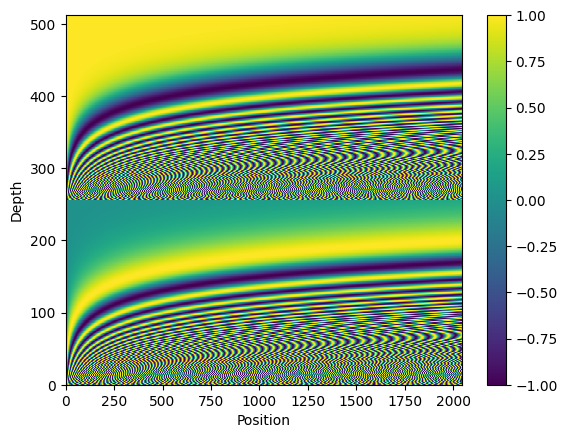

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T)
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [ ]:
embed_ru = PositionalEmbedding(vocab_size=tokenizers.russian.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.english.get_vocab_size(), d_model=512)

ru_emb = embed_ru(ru)
en_emb = embed_en(en)

In [ ]:
print(ru)

In [ ]:
print(ru_emb)

<tf.Tensor: shape=(64, 103, 512), dtype=float32, numpy=
array([[[-0.01119395, -0.5537729 , -0.5942012 , ...,  0.46283525,
          1.4341452 ,  1.9373078 ],
        [ 0.86147594,  1.9337792 ,  1.4713757 , ...,  1.7876112 ,
          1.5518761 ,  1.2678441 ],
        [ 0.97538394,  1.8458356 ,  1.297154  , ...,  1.3620536 ,
          1.7761623 ,  0.28659666],
        ...,
        [-1.0995511 ,  0.10388505, -0.5454693 , ...,  0.41857147,
          1.0103176 ,  1.4717768 ],
        [-0.14115962, -0.73509675,  0.12602949, ...,  0.41857022,
          1.0103164 ,  1.4717757 ],
        [ 0.40164137, -1.5384154 ,  1.004545  , ...,  0.41856897,
          1.0103152 ,  1.4717746 ]],

       [[-0.01119395, -0.5537729 , -0.5942012 , ...,  0.46283525,
          1.4341452 ,  1.9373078 ],
        [ 1.475219  , -0.2651865 ,  0.02239209, ...,  0.8330697 ,
          1.3010073 ,  0.75070155],
        [ 0.07366472,  0.33786982,  0.53925544, ...,  1.6558044 ,
          1.7013893 ,  1.4760716 ],
        ...

### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.


In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### The global self attention layer

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### The causal self attention layer

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### The cross attention layer

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

### Feedforward Network

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, NU, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(NU, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, NU, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, NU)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

### The encoder

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               NU, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     NU=NU,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               NU,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, NU)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, NU, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     NU=NU, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

## The Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, NU,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, NU=NU,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, NU=NU,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

Instantiate the `Transformer` model:

In [ ]:
num_layers=6
d_model=128
num_heads=8
NU=512
dropout_rate=0.1

In [ ]:
transformer = Transformer(
    num_layers= num_layers,
    d_model= d_model,
    num_heads= num_heads,
    NU=NU,
    input_vocab_size=tokenizers.russian.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.english.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((ru, en))

print(en.shape)
print(ru.shape)
print(output.shape)

(64, 95)
(64, 103)
(64, 95, 7796)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 95, 103)


Print the summary of the model:

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4960768   
                                                                 
 decoder (Decoder)           multiple                  8122624   
                                                                 
 dense_24 (Dense)            multiple                  1005684   
                                                                 
Total params: 14089076 (53.75 MB)
Trainable params: 14089076 (53.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer



$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

### Set up the loss and metrics

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

In [ ]:
transformer.compile( loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=15,
                validation_data=val_batches)

Epoch 1/15
3252/3252 [==============================] - 1381s 407ms/step - loss: 4.9400 - masked_accuracy: 0.2578 - val_loss: 3.7210 - val_masked_accuracy: 0.3638
Epoch 2/15
3252/3252 [==============================] - 1244s 382ms/step - loss: 3.5261 - masked_accuracy: 0.3822 - val_loss: 3.0352 - val_masked_accuracy: 0.4464
Epoch 3/15
3252/3252 [==============================] - 1242s 382ms/step - loss: 3.0137 - masked_accuracy: 0.4407 - val_loss: 2.7510 - val_masked_accuracy: 0.4833
Epoch 4/15
3252/3252 [==============================] - 1236s 380ms/step - loss: 2.7583 - masked_accuracy: 0.4726 - val_loss: 2.5874 - val_masked_accuracy: 0.5041
Epoch 5/15
3252/3252 [==============================] - 1234s 379ms/step - loss: 2.6059 - masked_accuracy: 0.4929 - val_loss: 2.5069 - val_masked_accuracy: 0.5158
Epoch 6/15
3252/3252 [==============================] - 1235s 380ms/step - loss: 2.4992 - masked_accuracy: 0.5079 - val_loss: 2.4325 - val_masked_accuracy: 0.5292
Epoch 7/15
3252/3252 [

## Run inference

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.russian.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.english.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.english.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.english.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Create an instance of this `Translator` class, and try it out a few times:

In [ ]:
translator = Translator(tokenizers, transformer)

Example 1:

In [ ]:
sentence = 'Это проблема, которую мы должны решить.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights =  translator(tf.constant(sentence))

print(f'{"Input:":15s}: {sentence}')
print(f'{"Prediction":15s}: {translated_text.numpy().decode("utf-8")}')
print(f'{"Ground truth":15s}: {ground_truth}')


Input:         : Это проблема, которую мы должны решить.
Prediction     : that ' s the problem we have to solve .
Ground truth   : this is a problem we have to solve .


## Export the model

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [ ]:
translator = ExportTranslator(translator)

In [ ]:
translator('это первый курс, который мы сделали').numpy().decode("utf-8")

'this is the first course we did .'

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

## Run inference from the saved model

In [ ]:
# !pip install tensorflow_text

In [1]:
# import tensorflow as tf
# import tensorflow_text as text

In [2]:
reloaded = tf.saved_model.load('translator')

In [3]:
reloaded('это первый курс, который мы сделали').numpy().decode("utf-8")

'this is the first course we did .'

# Archive the model into a zip file

In [ ]:
import shutil
import os.path

# Creating the ZIP file
archived = shutil.make_archive('translator_model', 'zip', '/content/translator')

## Downlaod the model

In [ ]:
from google.colab import files

files.download('/content/translator_model.zip')
